# Single time step prediction
## — with multiple input 

In [2]:
# Import to be able to import python package from src
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import tensorflow as tf
from darts.datasets import EnergyDataset
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

import ontime as on
from ontime.module import preprocessing

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
/Users/fred.montet/Library/Caches/pypoetry/virtualenvs/ontime-FpQu8-YN-py3.10/lib/python3.10/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


---
## Load data

In [3]:
ts = EnergyDataset().load()
ts = ts.astype(np.float32)

In [4]:
ts = ts.univariate_component(0)

---

## Preprocessing

In [5]:
# Fill missing values
transformer = MissingValuesFiller()
ts = transformer.transform(ts)

# Normalize
ts_t = preprocessing.common.normalize(ts)

# Train test split
train, test = preprocessing.common.train_test_split(ts_t, train_split=0.8)

# Split in vectors of length n
train_list = preprocessing.common.split_by_length(train, length=6, shift=6)
test_list = preprocessing.common.split_by_length(test, length=6, shift=6)

# Split each vector in input and target
X_train, y_train = preprocessing.common.split_inputs_from_targets(train_list, input_length=5, target_length=1)
X_test, y_test = preprocessing.common.split_inputs_from_targets(test_list, input_length=5, target_length=1)

# Convert to Numpy
X_train = preprocessing.common.timeseries_list_to_numpy(X_train)
y_train = preprocessing.common.timeseries_list_to_numpy(y_train)
X_test = preprocessing.common.timeseries_list_to_numpy(X_test)
y_test = preprocessing.common.timeseries_list_to_numpy(y_test)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4675, 5, 1)
(4675, 1, 1)
(1168, 5, 1)
(1168, 1, 1)


---
## Modelling

In [7]:
input_shape = X_train[0].shape
output_shape = y_train[0].shape

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(output_shape[0])
])

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

model.fit(
    X_train,
    y_train,
    epochs=4
)

absl       WARNING At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/4
147/147 [==============================] - 0s 442us/step - loss: 0.0872 - mean_absolute_error: 0.1609
Epoch 2/4
147/147 [==============================] - 0s 392us/step - loss: 0.0021 - mean_absolute_error: 0.0355
Epoch 3/4
147/147 [==============================] - 0s 339us/step - loss: 0.0018 - mean_absolute_error: 0.0319
Epoch 4/4
147/147 [==============================] - 0s 325us/step - loss: 0.0015 - mean_absolute_error: 0.0280


### Evaluate 

In [11]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 0s 423us/step - loss: 0.0014 - mean_absolute_error: 0.0265


[0.0013810864184051752, 0.02650505304336548]

---
## Predict

In [12]:
y_pred = model.predict(X_test)

37/37 [==============================] - 0s 382us/step


In [13]:
mape(y_pred.squeeze(), y_test.squeeze())

0.0480228

<Axes: >

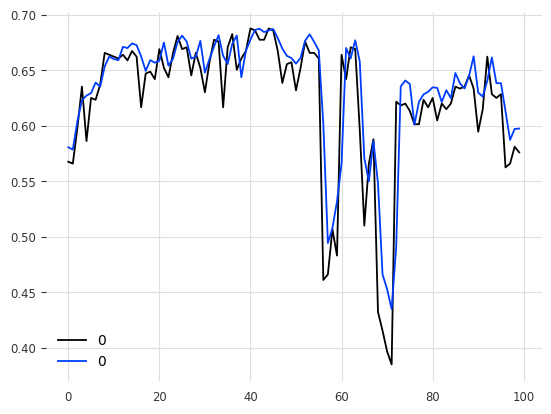

In [14]:
start = 500
width = 100

fig, ax = plt.subplots()
pd.DataFrame(y_test.squeeze()[start:start+width]).plot(ax=ax)
pd.DataFrame(y_pred.squeeze()[start:start+width]).plot(ax=ax)